In [1]:
import json
import statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
import sklearn.cluster as cluster
import time
import scipy
import seaborn as sns
import random
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha': 0.25, 's':80, 'linewidths':0}

# set up type of service

In [2]:
# user input
user_input = 'Restaurants'
# u_id = 'McLqvYLBQoCFQikU9dC4cQ'

# read in business file, compose business categories, business rating on category and business postal code dictionary

In [3]:
# initialize business data
bcmap = {}
with open('./business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        
        key = l['business_id']
        #Business Category Dictionary
        category = l['categories']
        bcmap[key] = category

# generate top categories
category = {}
for i in bcmap:
    if user_input in bcmap[i]:
        for j in bcmap[i]:
            if j not in category:
                category[j] = 1
            else:
                category[j] += 1
top_cate = sorted(category.items(), key=lambda x:(-x[1]))[1:21]
tc = []
for i in top_cate:
    tc.append(i[0])
    
# initialize business data   
location = {}
bcrmap = {}
business_name = {}
with open('./business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        key = l['business_id']
        category = l['categories']
        
        # Business City Dictionary
        city = l['state']
        location[key] = city
        
        # Business -> Category -> Star Dictionary
        stars = l['stars']
        valid = False
        number_of_tc = 0
        if city not in bcrmap:
            bcrmap[city] = {}
        if key not in bcrmap[city]:
            bcrmap[city][key] = {}
        for i in category:
            if i in tc:
                number_of_tc += 1
                valid = True
                bcrmap[city][key].setdefault(i,[]).append(stars)
        if not valid or number_of_tc <3:
            del bcrmap[city][key]
            
            
        # Business name -> Address Dictionary
        name = l['name'] +','  + l['address'] +','  + l['city'] +',' + l['state']
        business_name[key] = name
        

# read in review file and generate user to category to rating map

In [4]:
# initialize user review data
# User -> Categories -> Stars
ucrmap = {}
test_urcmap = {}
user_rating = {}
with open('./review.json', 'r') as rv:
    for line in rv:
        n1 = json.loads(line)
        okey = n1['user_id']
        year = n1['date']
        ikeys = bcmap[n1['business_id']]
        bid = n1['business_id']
        value = n1['stars']
        city = location[bid]
        if city not in user_rating:
            user_rating[city] = {}
        user_rating[city].setdefault(okey, []).append(value)
        if city not in ucrmap:
            ucrmap[city]  = {}
        if city not in test_urcmap:
            test_urcmap[city]  = {}
        if int(n1['date'].split('-')[0]) < 2016:
            if okey not in ucrmap[city]:
                ucrmap[city][okey] = {}
            for ikey in ikeys:
                if ikey in tc:
                    ucrmap[city][okey].setdefault(ikey, []).append(value)
        else:
            if okey not in test_urcmap:
                test_urcmap[city][okey] = {}
            test_urcmap[city][okey][bid] = value

In [5]:
listCity = {}
for i in ucrmap:
    if i in bcrmap:
        listCity[i] = {}
        listCity[i]['user'] = len(ucrmap[i])
        listCity[i]['business'] = len(bcrmap[i])

In [6]:
len(listCity)

51

In [7]:
sorted_by_business = sorted(listCity.items(), key=lambda x: -x[1]['business'])
sorted_by_business

[('AZ', {'business': 2933, 'user': 227835}),
 ('ON', {'business': 2289, 'user': 67838}),
 ('NV', {'business': 1801, 'user': 307931}),
 ('OH', {'business': 1514, 'user': 40599}),
 ('PA', {'business': 1099, 'user': 37990}),
 ('NC', {'business': 1091, 'user': 47382}),
 ('QC', {'business': 679, 'user': 23852}),
 ('WI', {'business': 511, 'user': 19821}),
 ('BW', {'business': 341, 'user': 10648}),
 ('EDH', {'business': 319, 'user': 6766}),
 ('IL', {'business': 147, 'user': 7774}),
 ('SC', {'business': 67, 'user': 2966}),
 ('MLN', {'business': 12, 'user': 756}),
 ('HLD', {'business': 7, 'user': 448}),
 ('FIF', {'business': 5, 'user': 186}),
 ('NY', {'business': 3, 'user': 69}),
 ('NYK', {'business': 3, 'user': 142}),
 ('ST', {'business': 2, 'user': 36}),
 ('ELN', {'business': 2, 'user': 125}),
 ('WA', {'business': 2, 'user': 36}),
 ('C', {'business': 2, 'user': 70}),
 ('KHL', {'business': 1, 'user': 7}),
 ('ABE', {'business': 1, 'user': 6}),
 ('NI', {'business': 1, 'user': 47}),
 ('01', {'bus

In [8]:
sorted_by_user = sorted(listCity.items(), key=lambda x: -x[1]['user'])
sorted_by_user

[('NV', {'business': 1801, 'user': 307931}),
 ('AZ', {'business': 2933, 'user': 227835}),
 ('ON', {'business': 2289, 'user': 67838}),
 ('NC', {'business': 1091, 'user': 47382}),
 ('OH', {'business': 1514, 'user': 40599}),
 ('PA', {'business': 1099, 'user': 37990}),
 ('QC', {'business': 679, 'user': 23852}),
 ('WI', {'business': 511, 'user': 19821}),
 ('BW', {'business': 341, 'user': 10648}),
 ('IL', {'business': 147, 'user': 7774}),
 ('EDH', {'business': 319, 'user': 6766}),
 ('SC', {'business': 67, 'user': 2966}),
 ('MLN', {'business': 12, 'user': 756}),
 ('HLD', {'business': 7, 'user': 448}),
 ('FL', {'business': 0, 'user': 349}),
 ('FIF', {'business': 5, 'user': 186}),
 ('NYK', {'business': 3, 'user': 142}),
 ('ELN', {'business': 2, 'user': 125}),
 ('WLN', {'business': 1, 'user': 110}),
 ('C', {'business': 2, 'user': 70}),
 ('NY', {'business': 3, 'user': 69}),
 ('NI', {'business': 1, 'user': 47}),
 ('CA', {'business': 0, 'user': 44}),
 ('ST', {'business': 2, 'user': 36}),
 ('WA', {'

In [9]:
def recommend_based_on_state(state):
    print('============================================')
    print('Recommendation info summary for : ', state)

    City_of_Data = state
   
    # pre-process data: build up user and business data set based on state
    filter_user = {}
    valid_user = {}
    valid_test_user = {}
    for i in user_rating[City_of_Data]:
        if len(user_rating[City_of_Data][i]) >= 20:
            filter_user[i] = len(user_rating[City_of_Data][i])
    raw = sorted(filter_user.items(), key=lambda x:-x[1])
    valid_list = []
    for k, v in raw:
        if k in ucrmap[City_of_Data] and k in test_urcmap[City_of_Data]:
            valid_list.append(k)
            valid_user[k] = ucrmap[City_of_Data][k]
            valid_test_user[k] = test_urcmap[City_of_Data][k]
            
    print('number of valid user: ', len(valid_user))
    print('number of valid test user: ', len(valid_user))
    
    #generate business category dict with pure vector
    def generate_nbcrmap(data):
        for business in data:
            for k, v in data[business].items():
                data[business][k] = statistics.mean(v)

        for business in data:
            for i in tc:
                if i not in data[business]:
                    data[business][i] = 3.12

        nbcrmap = {}
        for k, v in data.items():
            nbcrmap[k] = []
            value = []
            for i in tc:
                value.append(v[i])
            nbcrmap[k] = value
        return nbcrmap

    nbcrmp = generate_nbcrmap(bcrmap[City_of_Data])
    
    # Compose user category vector
    def generate_nucrmap(data):
        for user in data:
            for cate, value in data[user].items():
                data[user][cate] = statistics.mean(value)
        for user in data:
            for i in tc:
                if i not in data[user]:
                    data[user][i] = 3.12

        nucrmap = {}
        for k, v in data.items():
            nucrmap[k] = []
            value = []
            for i in tc:
                value.append(v[i])
            nucrmap[k] = value
        return nucrmap

    nucrmap = generate_nucrmap(valid_user)
    
    data = nucrmap
    listV = list(data.values())
    listK = list(data.keys())
    
    # Agglomerative clustering using scipy
    Z = scipy.cluster.hierarchy.linkage(listV[:300], method='average')
    plt.clf()
    fig = plt.figure(figsize=(100, 60), dpi=100, facecolor='w', edgecolor='k')
    dd = scipy.cluster.hierarchy.dendrogram(Z)
    plt.savefig('{}.pdf'.format('average'))
    plt.show()
    
#     c, coph_dists = scipy.cluster.hierarchy.cophenet(Z, pdist(listV))
#     print("c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c="+repr(c))
    
    #agglomerative clustering using sklearn 
    data1 = []
    for k,v in nucrmap.items():
        data1.append(v)
    np.save('123', np.array(data1))
    data1 = np.load('123.npy')

    # get number of clusters from above plot and generate clusters dictionary
    model = cluster.AgglomerativeClustering(linkage='average', n_clusters=11)
    result = model.fit_predict(listV)
    clusters = {}
    for i in range(len(result)):
        k = result[i]
        v = data1[i]
        clusters.setdefault(k, []).append(v)

    # Average Vector for each cluster generated above

    average_vector = {}
    for i in list(clusters.keys()):
        average_vector[i] = np.mean(clusters[i], axis=0)

    def generate_recommendatioin(uid):
        index = listK.index(uid)
        uvector = average_vector[result[index]]
        r = {}
        for i in nbcrmp:
            r[i] = np.inner(uvector, nbcrmp[i])
        top_business = sorted(r.items(), key=lambda x:(-x[1]))[1:100]
        return [k for k,v in top_business]
    def cacluate_hr(uid, bids):
        score = 0
        count = 0
        for bid in bids:
            if bid in valid_test_user[uid]:
                count += 1
                if valid_test_user[uid][bid] > 3.7:
                    score += 1
                if valid_test_user[uid][bid] < 2.6:
                    score -= 1
        return np.array([score, count])
    
    def calculate_ndcg(uid, bids):
        gain = 0
        ind_list = []
        for i in range(len(bids)):
            bid = bids[i]
            if bid in valid_test_user[uid]:
                ind_list.append(i+1)
                gain += valid_test_user[uid][bid]/(i+1)
        idcg = 0
        for i in ind_list:
            idcg += 5/i
        if idcg == 0:
            return 0
        return gain/idcg

    def evaluate(list_test):
        hr = np.array([0,0])
        for uid in list_test:
            recs = generate_recommendatioin(uid)
            tmp = cacluate_hr(uid, recs)
            hr += tmp
        print('Hit Ratio: ', hr[0]/hr[1])
        print('============================================')
        print('\n\n\n\n')
        
    evaluate(valid_list)

In [10]:
valid_state = ['AZ', 'ON', 'NV', 'OH', 'PA', 'NC', 'QC', 'WI', 'BW', 'IL']

Recommendation info summary for :  AZ
number of valid user:  7672
number of valid test user:  7672


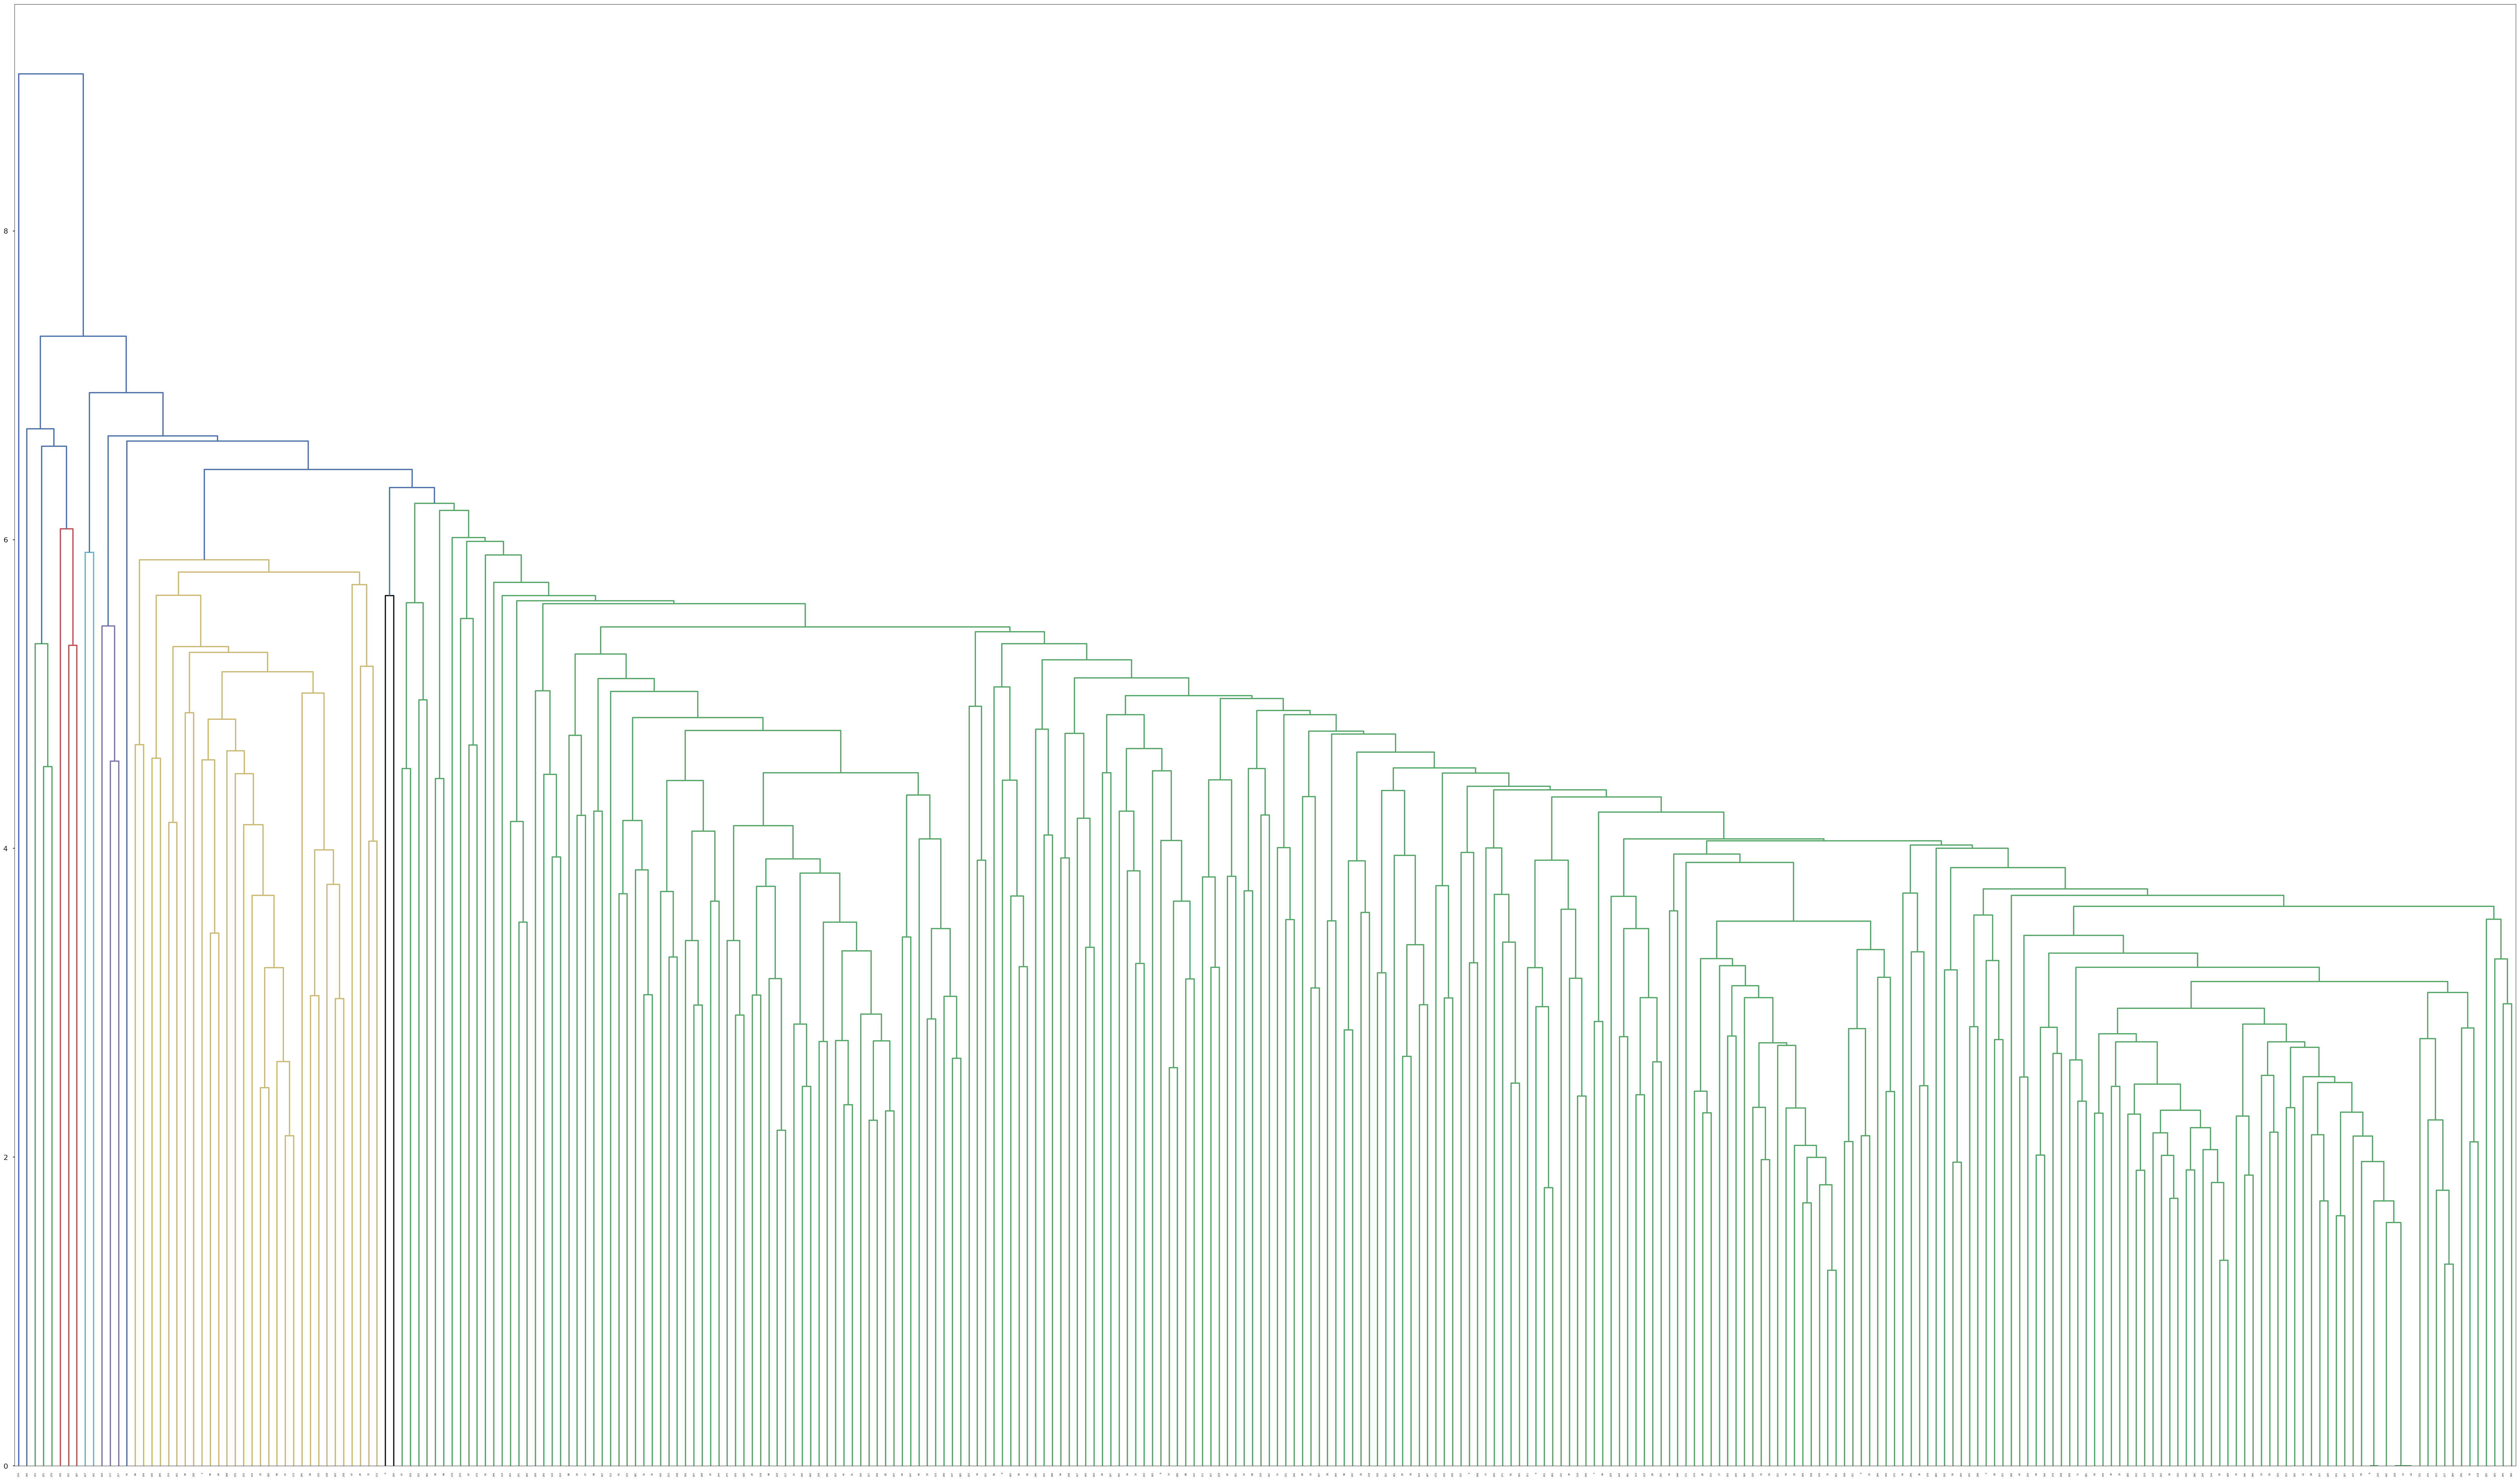

Hit Ratio:  0.68115942029





Recommendation info summary for :  ON
number of valid user:  3196
number of valid test user:  3196


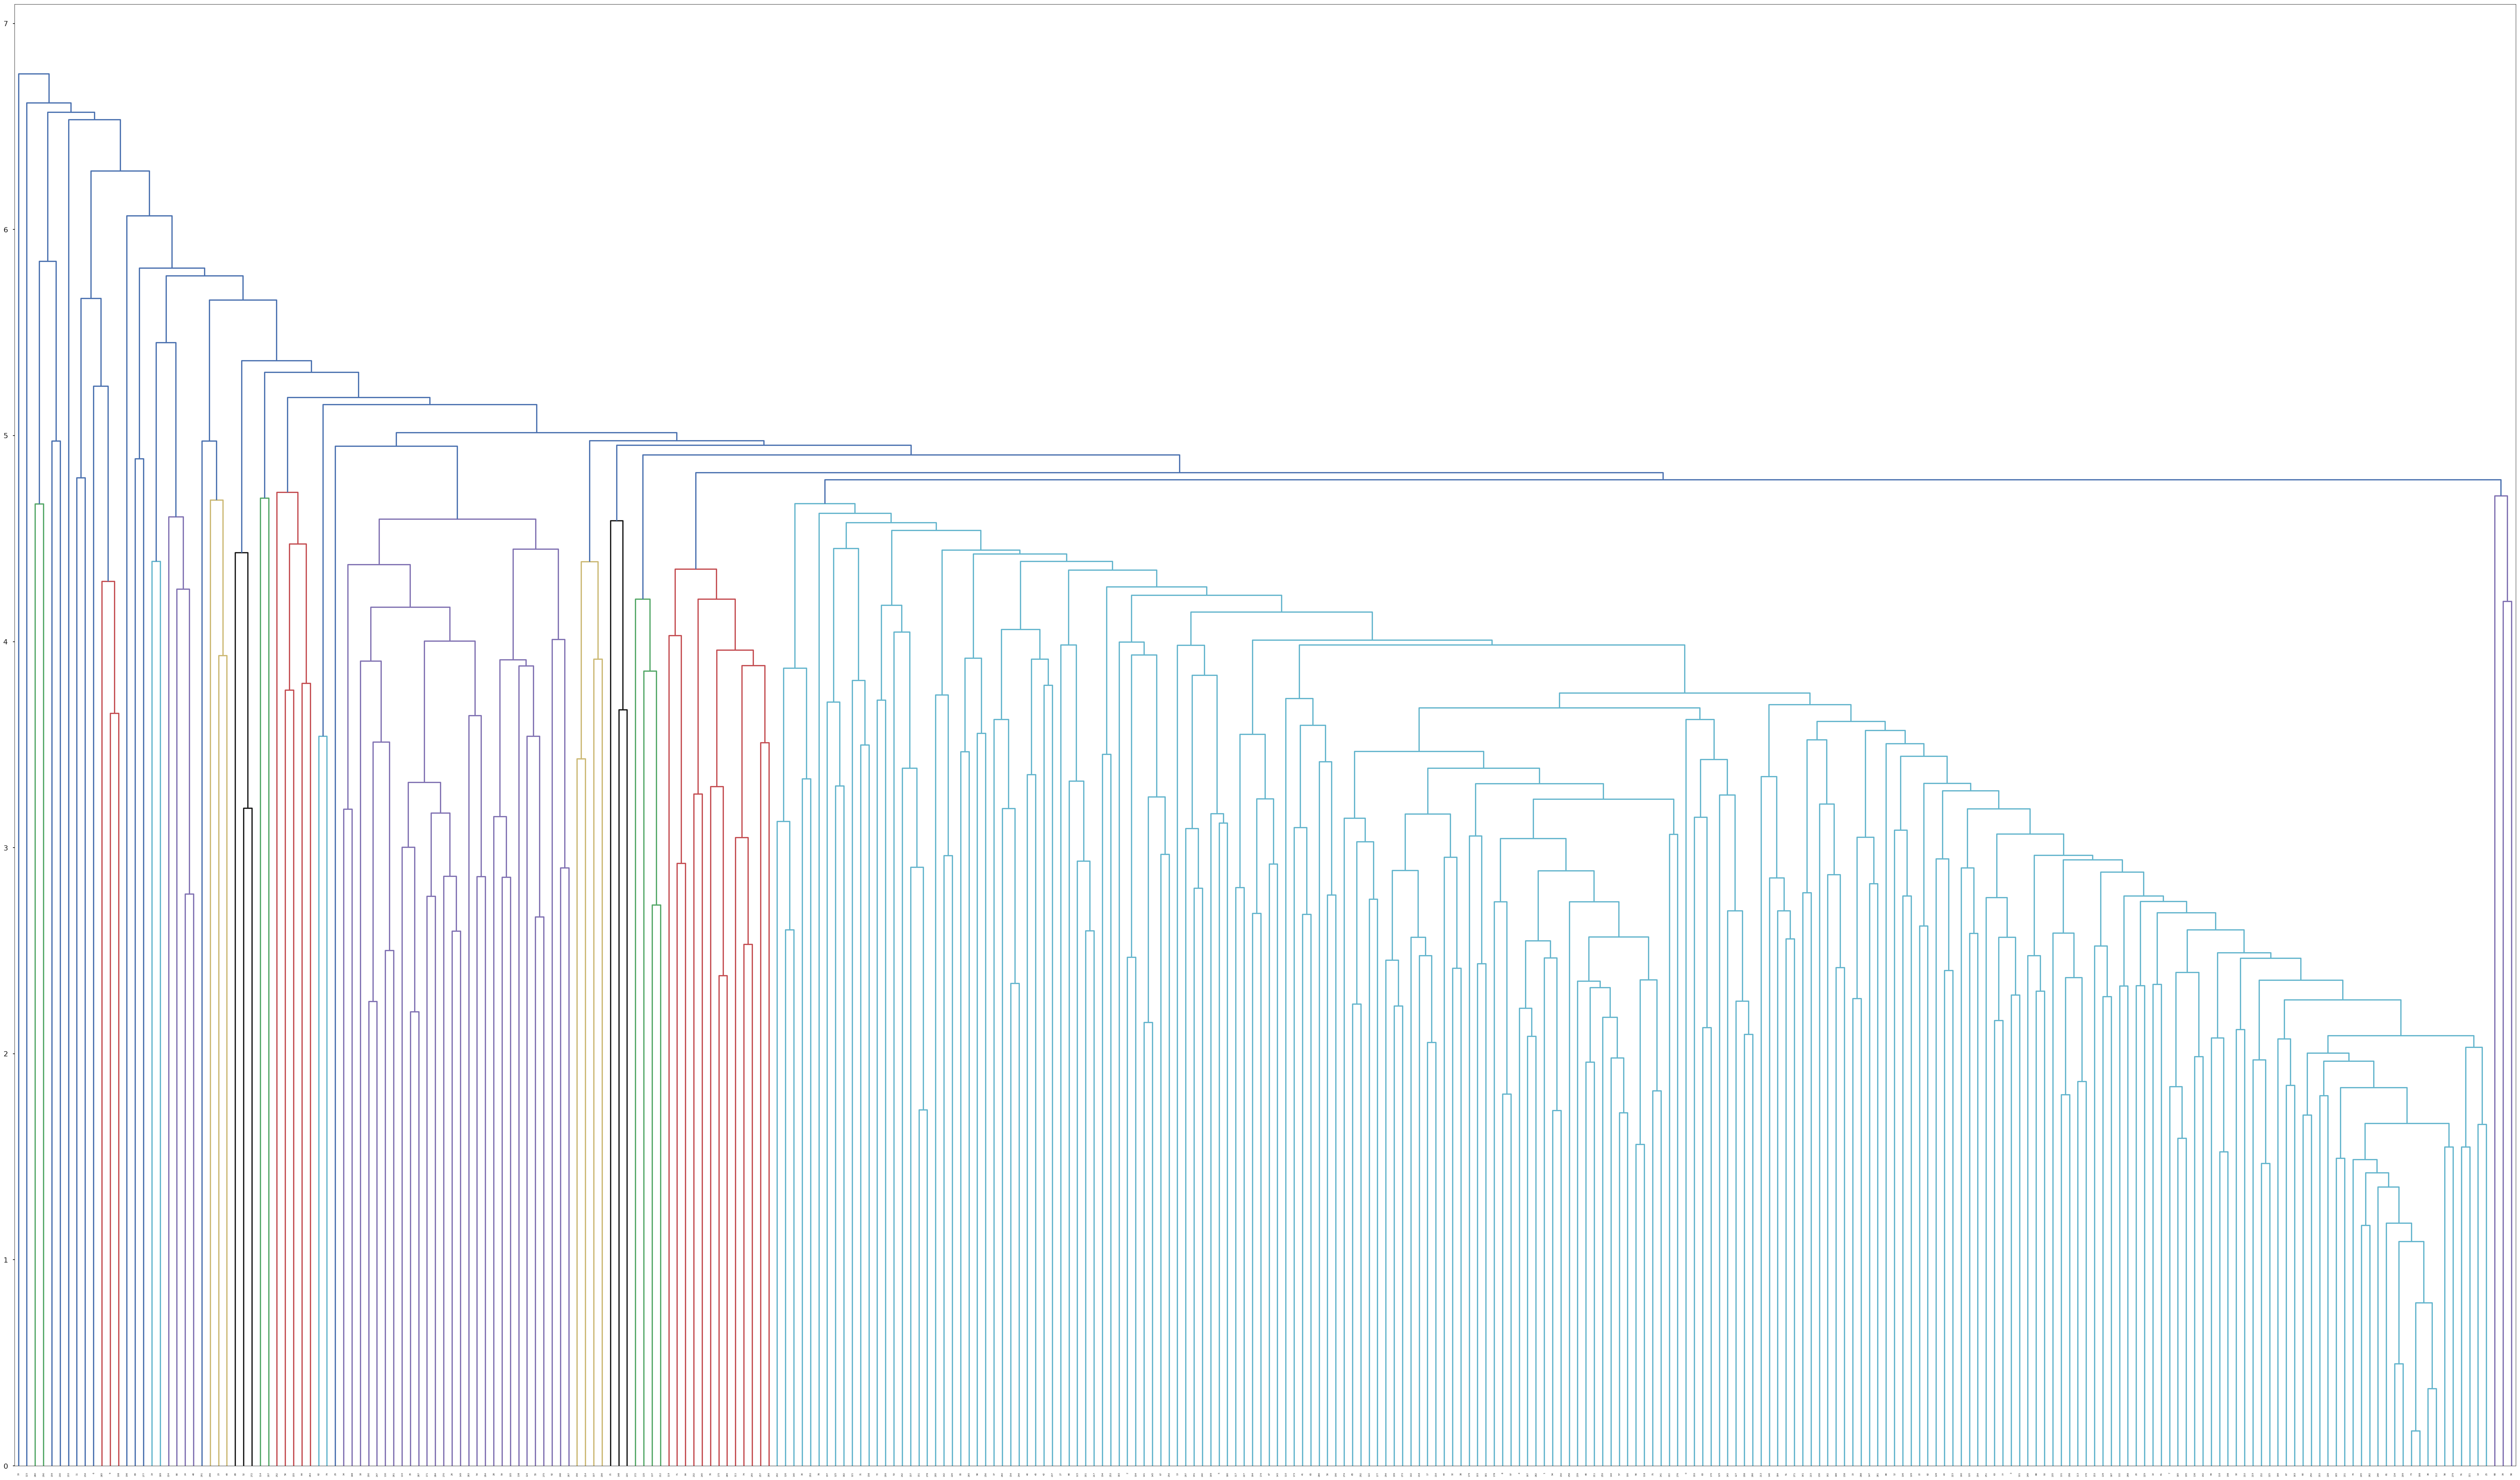

Hit Ratio:  0.866666666667





Recommendation info summary for :  NV
number of valid user:  7274
number of valid test user:  7274


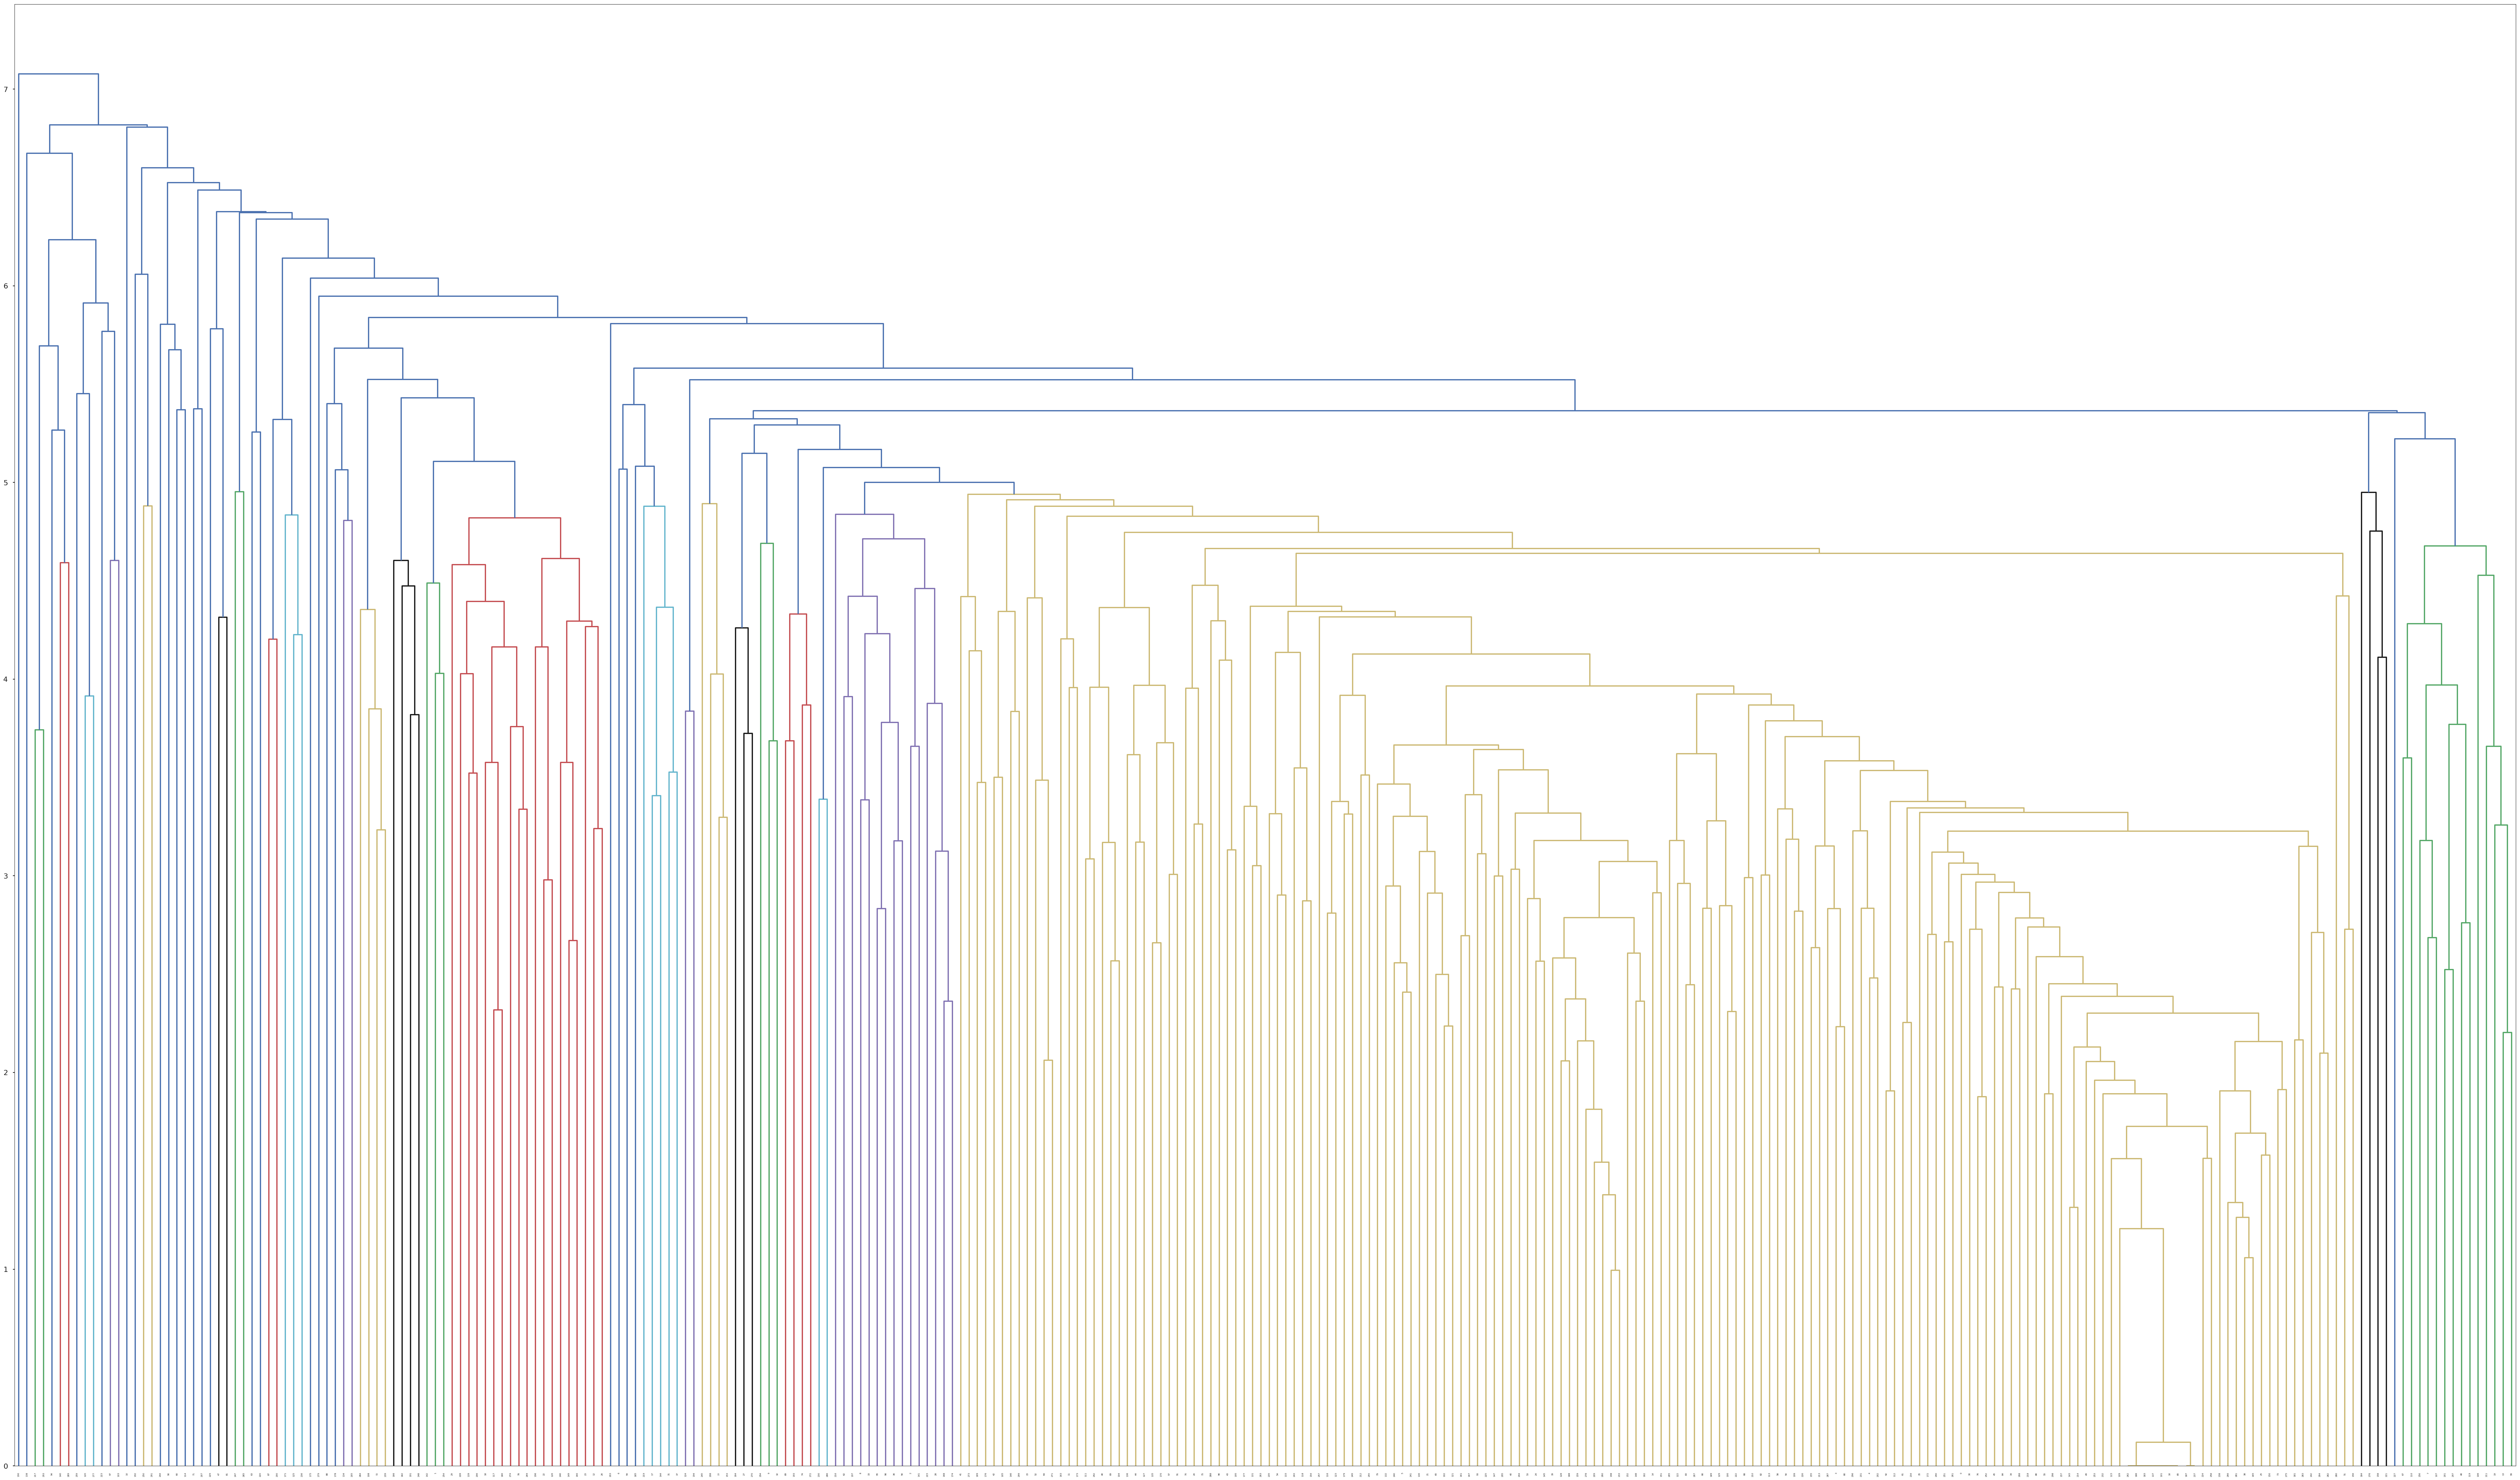

Hit Ratio:  0.618181818182





Recommendation info summary for :  OH
number of valid user:  949
number of valid test user:  949


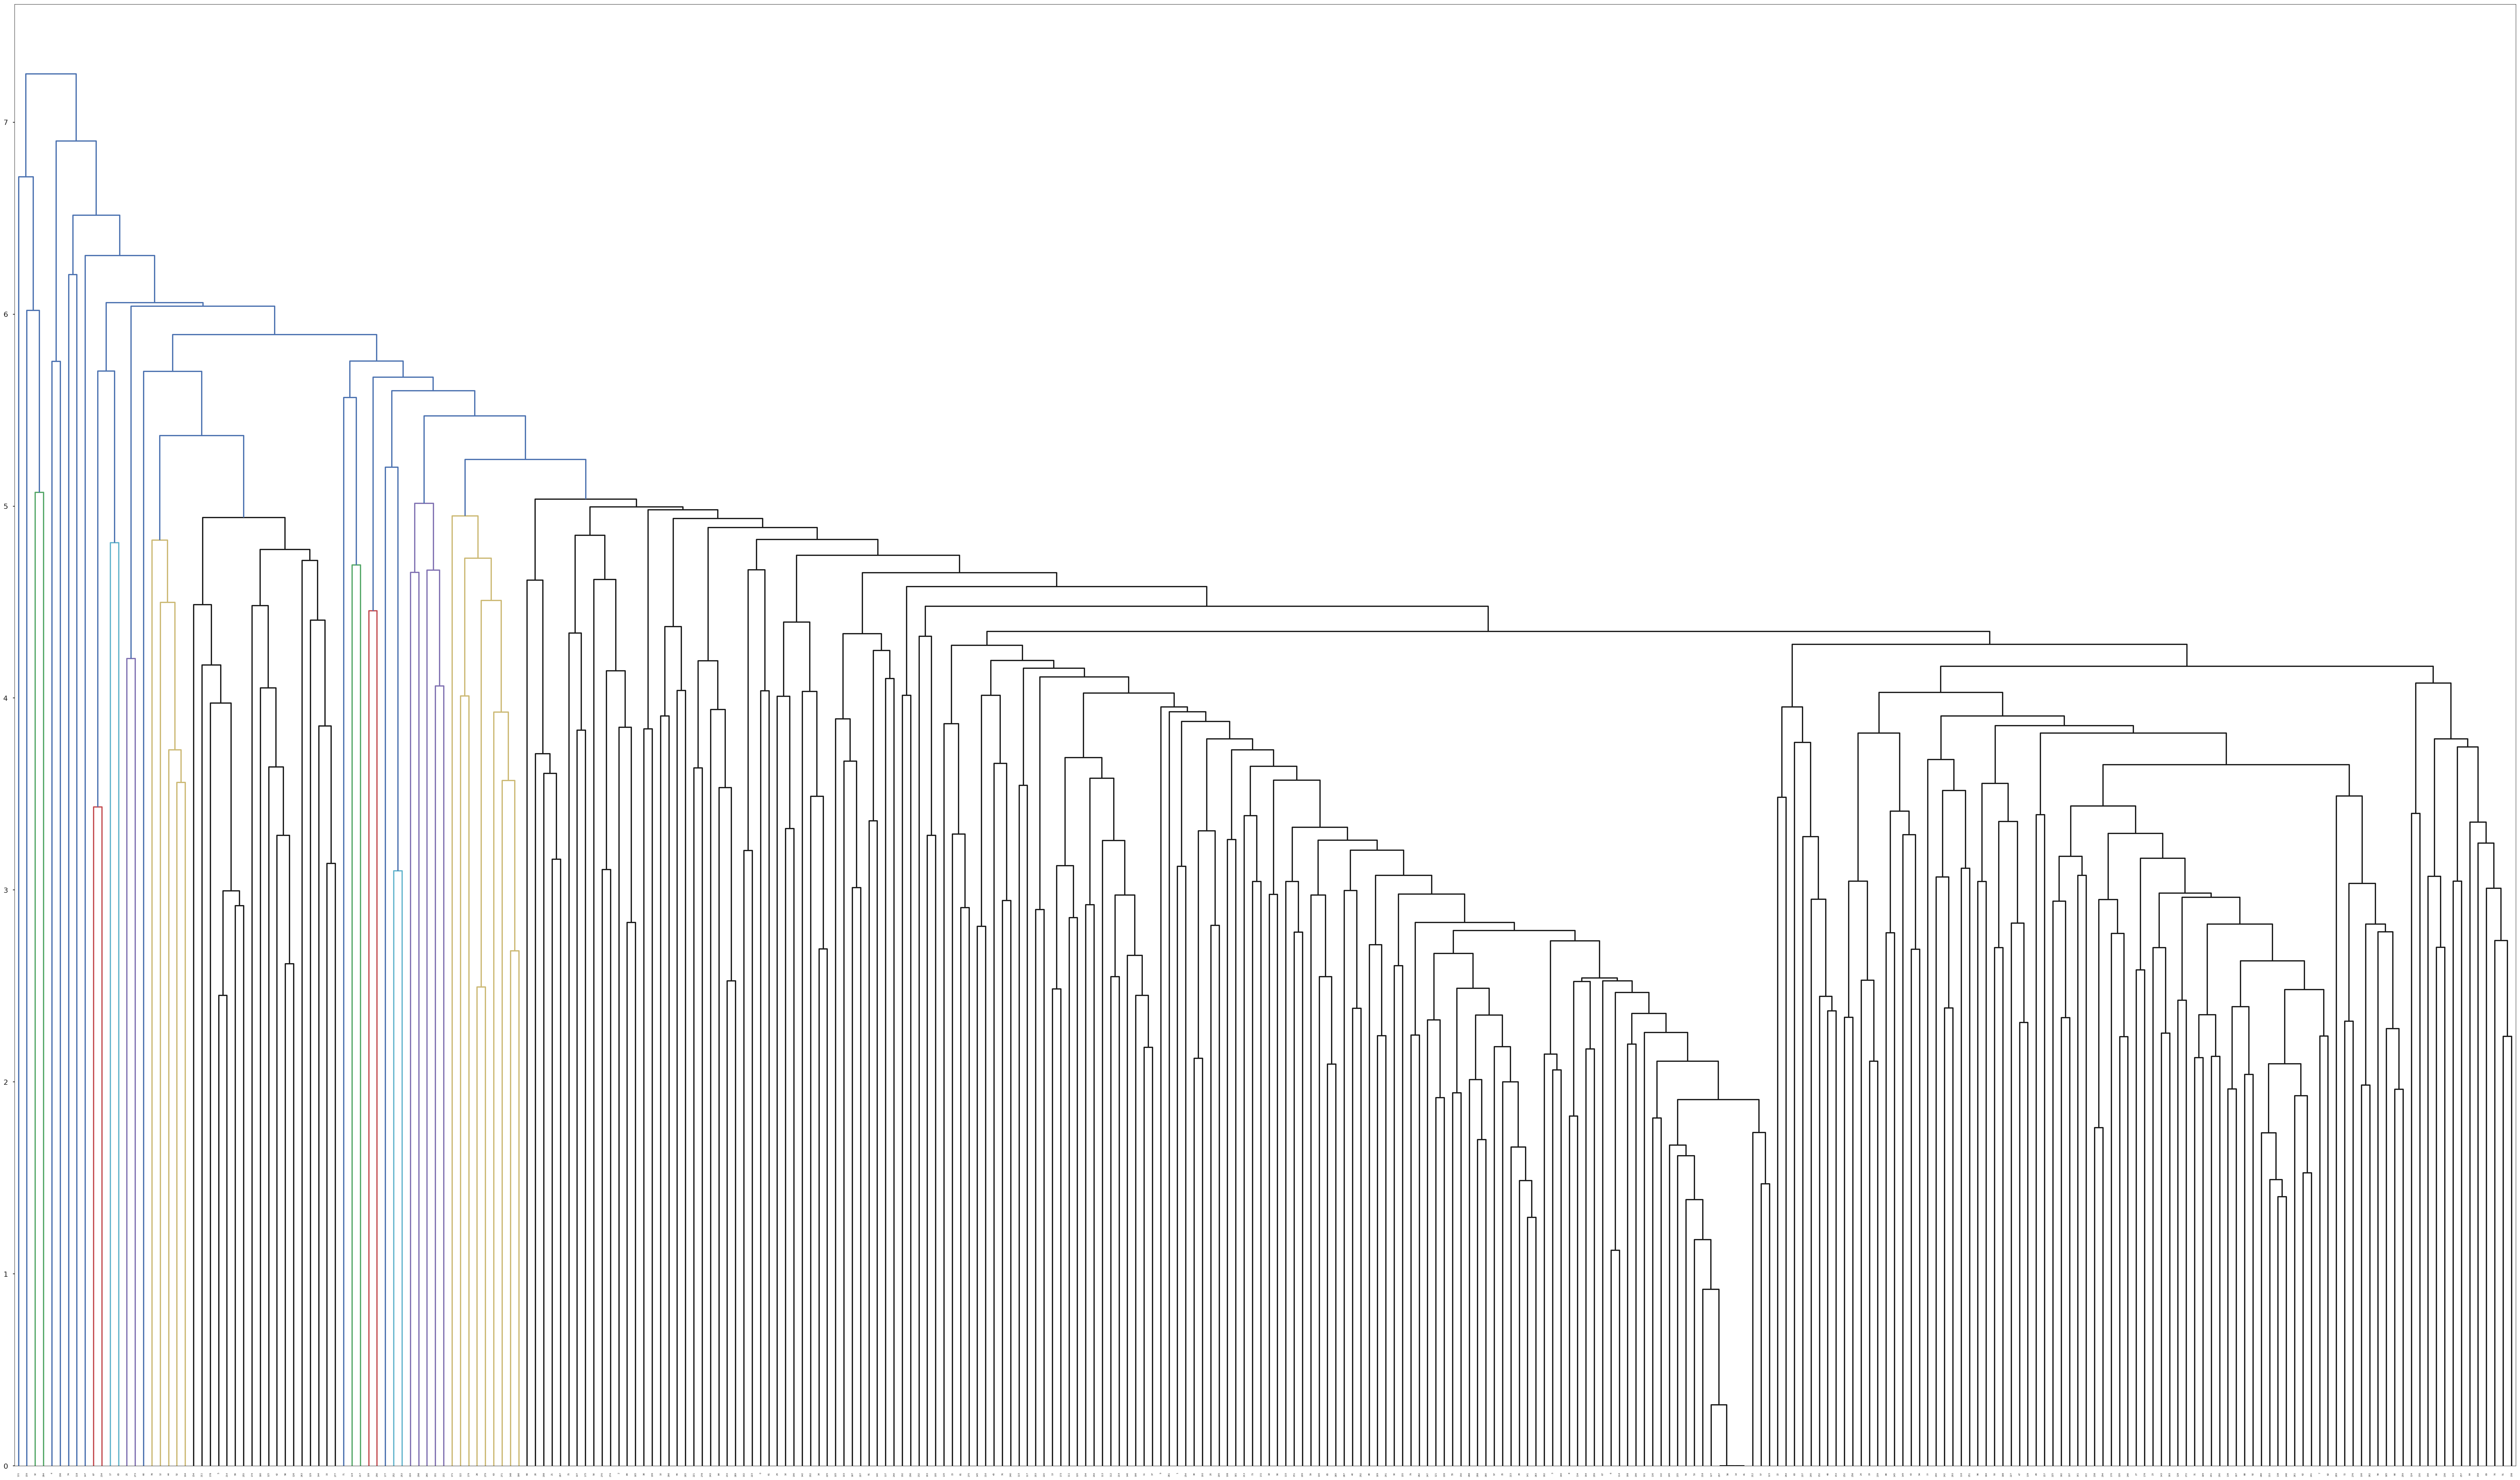

Hit Ratio:  0.888888888889





Recommendation info summary for :  PA
number of valid user:  846
number of valid test user:  846


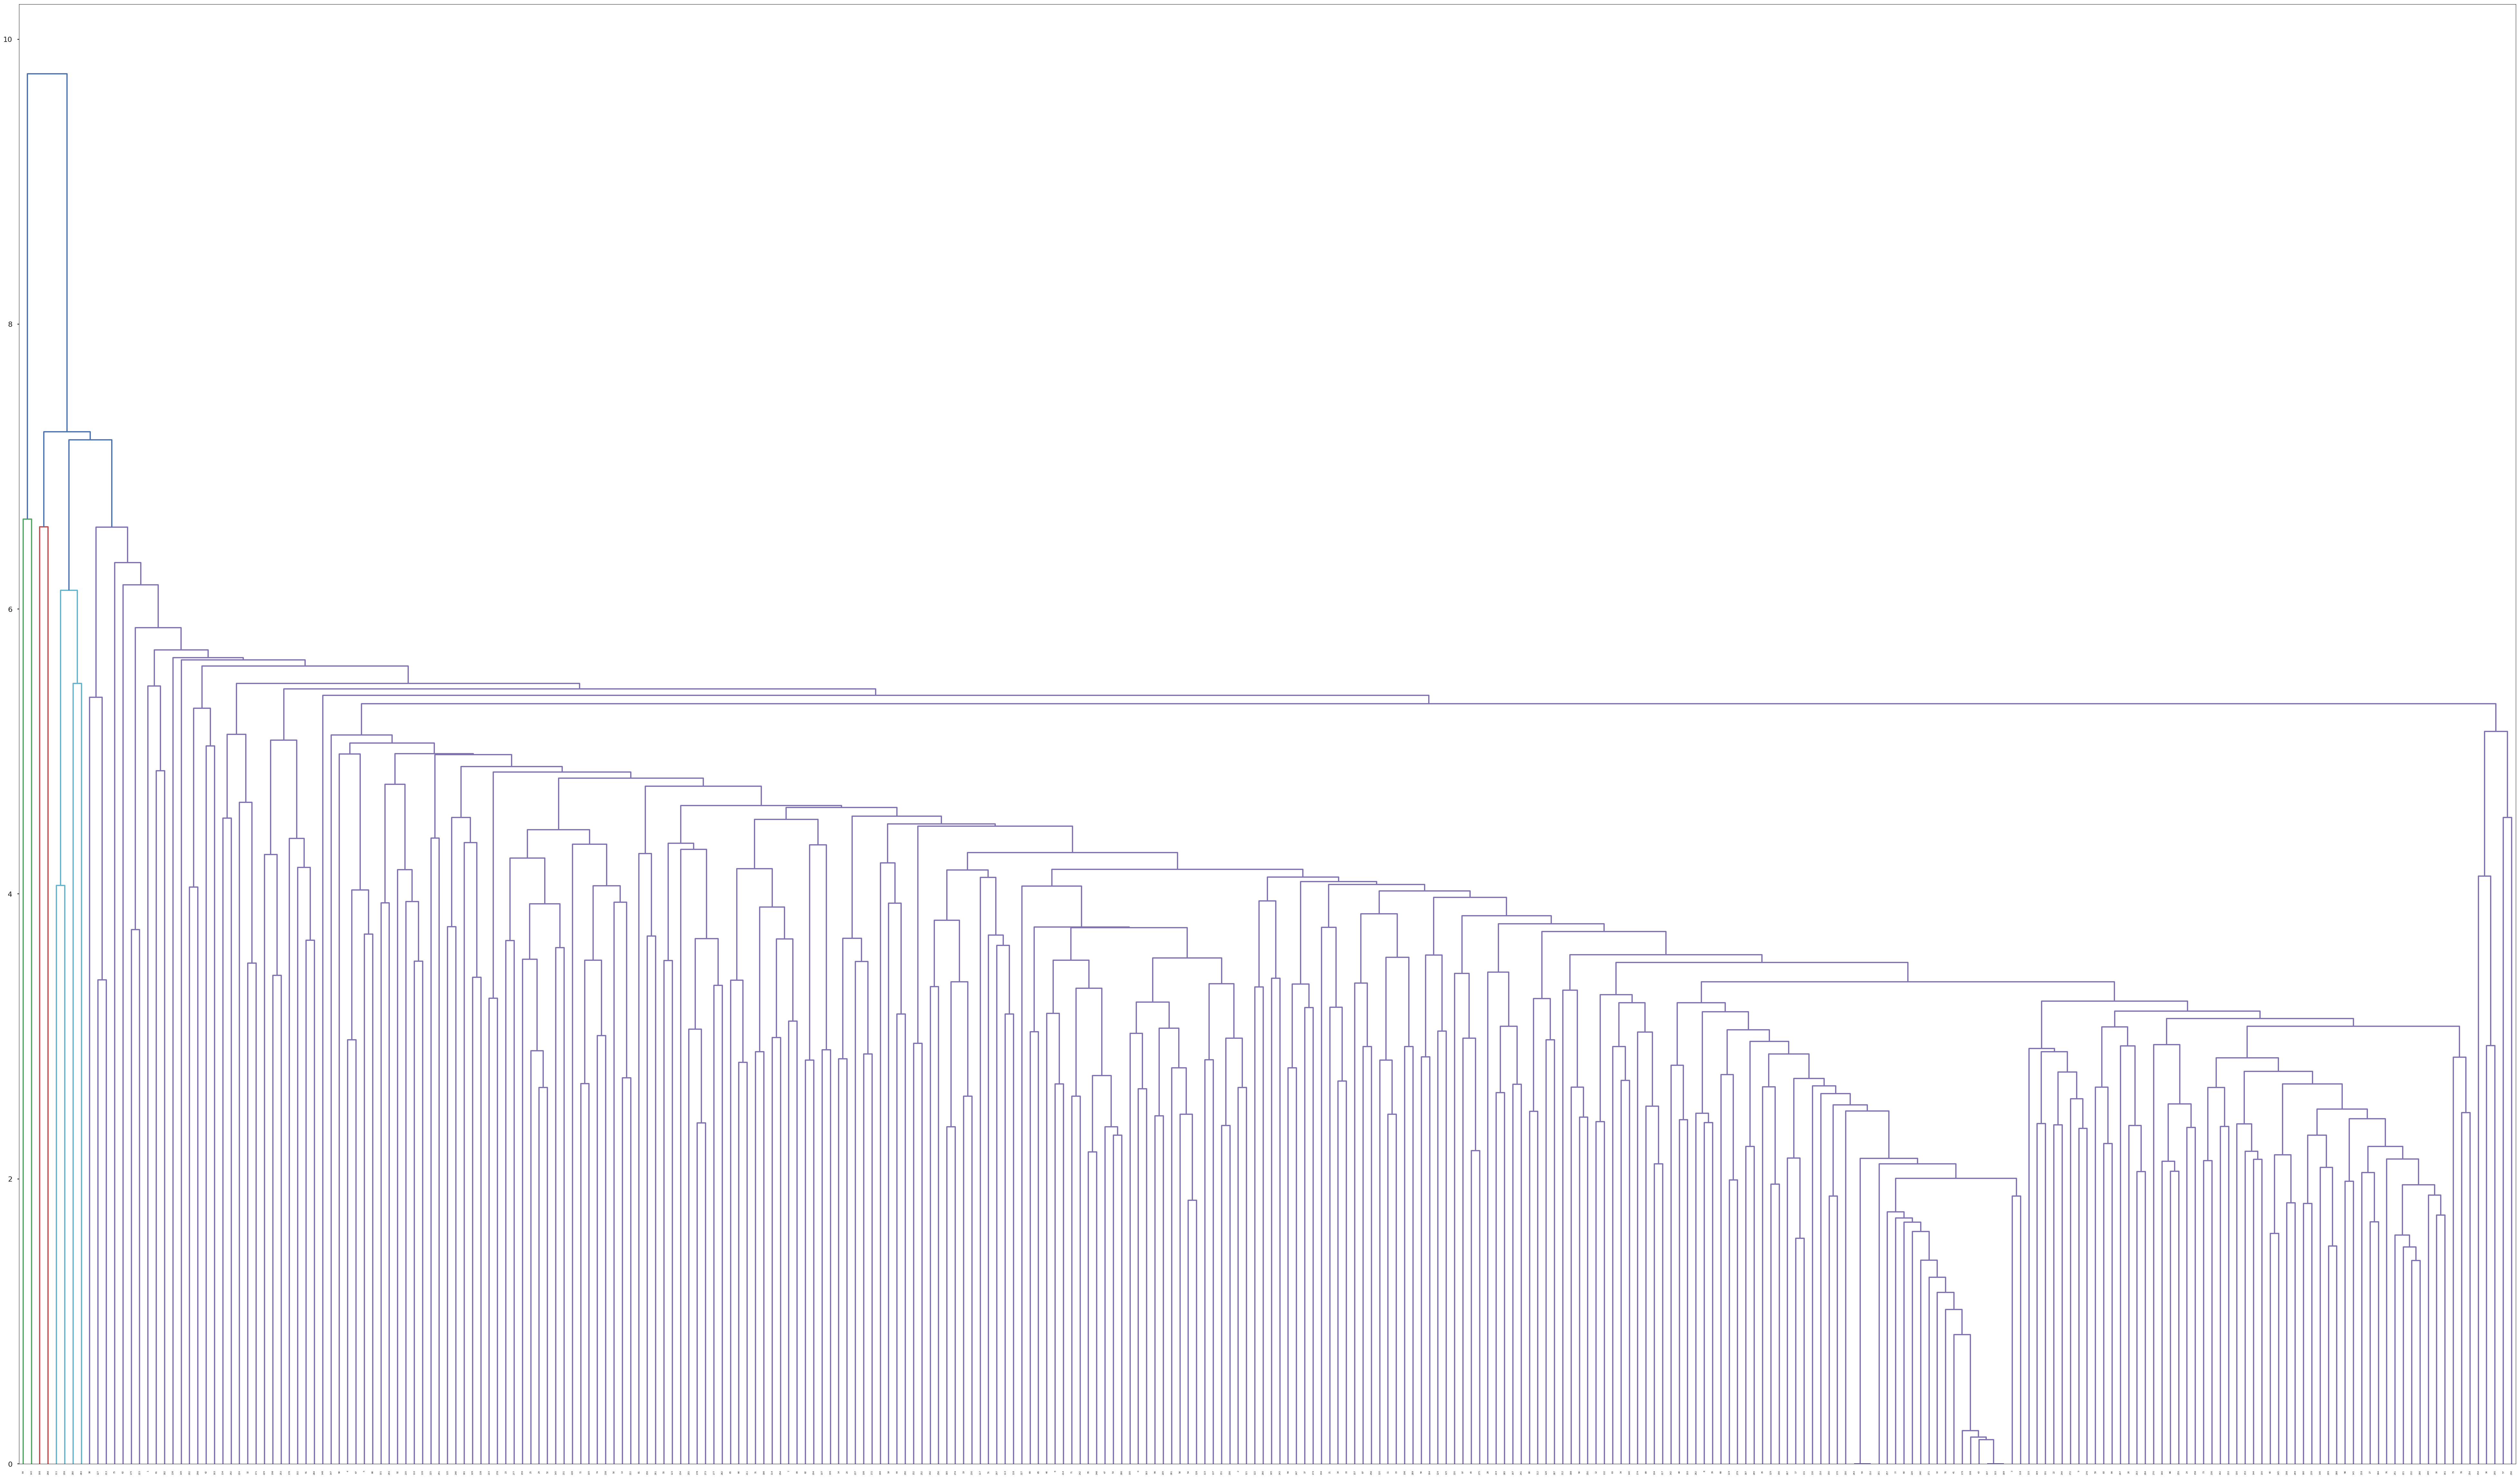

Hit Ratio:  0.923076923077





Recommendation info summary for :  NC
number of valid user:  1138
number of valid test user:  1138


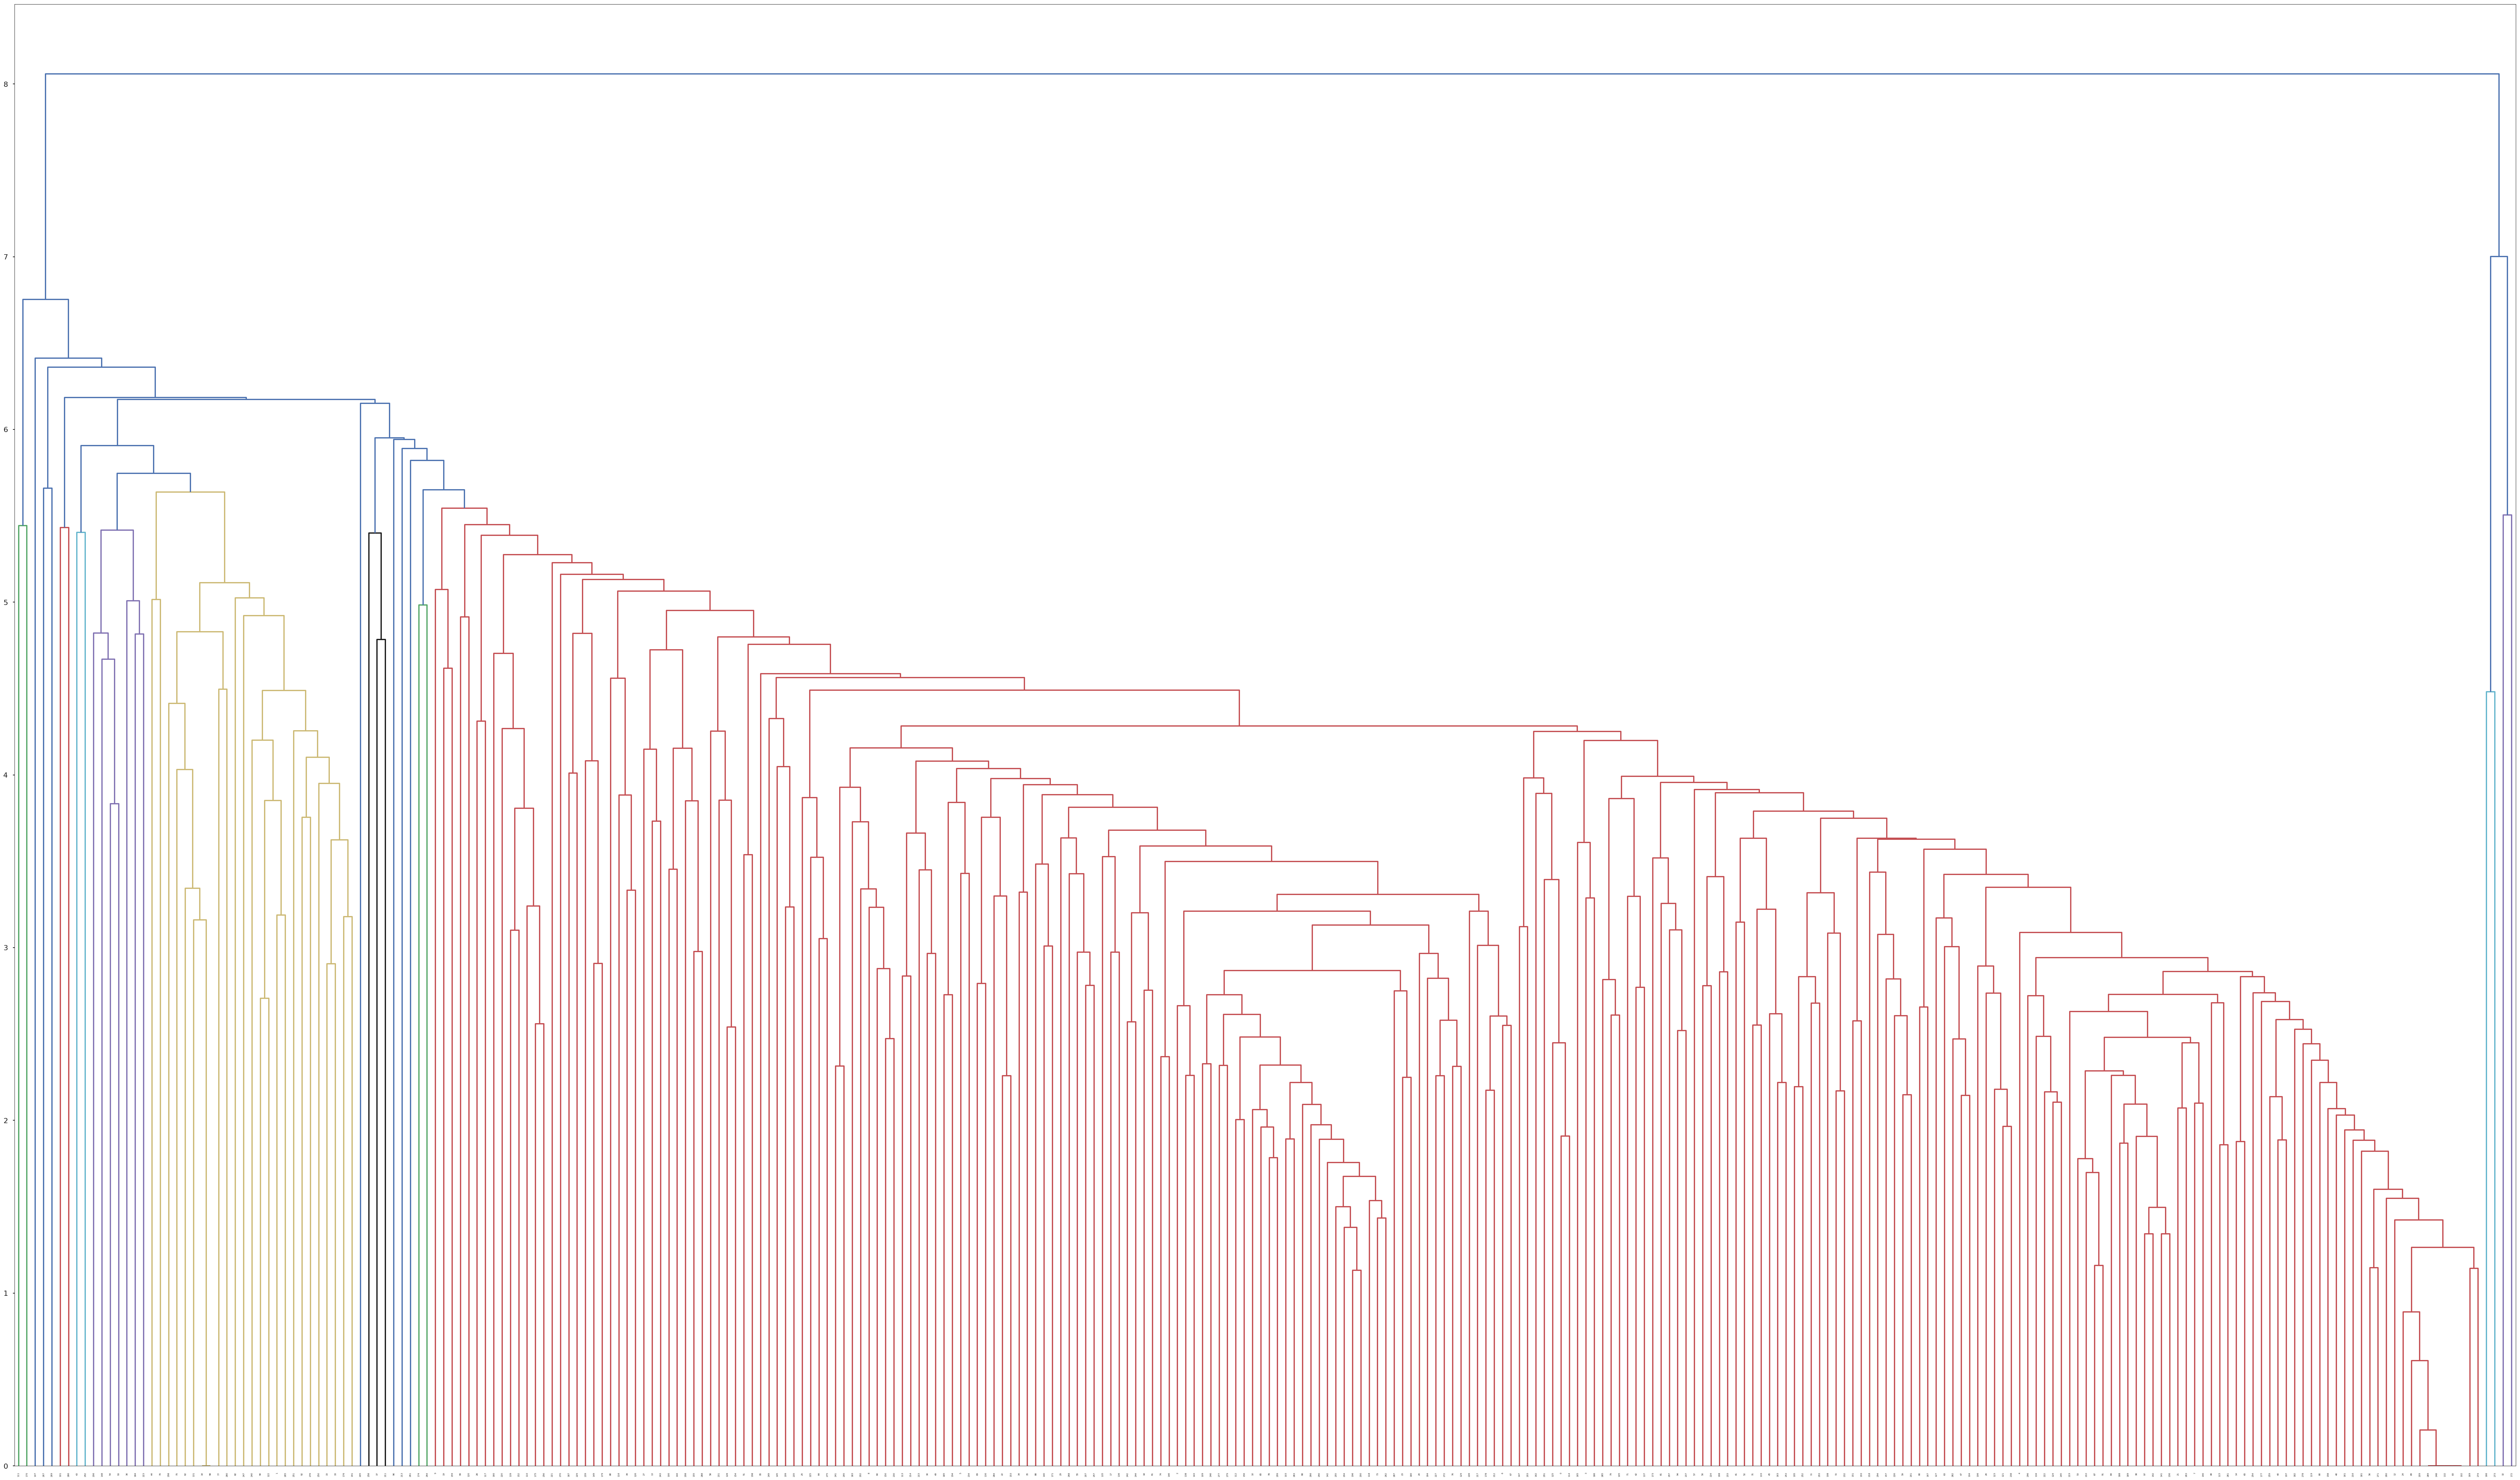

Hit Ratio:  0.852459016393





Recommendation info summary for :  QC
number of valid user:  466
number of valid test user:  466


MemoryError: In RendererAgg: Out of memory

Hit Ratio:  0.8





Recommendation info summary for :  WI
number of valid user:  446
number of valid test user:  446


MemoryError: In RendererAgg: Out of memory

In [11]:
for state in valid_state:
    recommend_based_on_state(state)